# Tests

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

In [4]:
df = pd.concat([data.data, data.target.rename("target")], axis=1)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
# from lightgbm import LGBMClassifier, LGBMRegressor

# LGBMRegressor()

# Modelling

In [6]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
# import xgboost as xgb

all_models = {
  'catboost': {
		'regression': CatBoostRegressor,
		'classification': CatBoostClassifier,
	},
	'lightgbm': {
   	'regression': LGBMRegressor,
		'classification': LGBMClassifier,
	}
}


In [7]:

cb_params = {
    'iterations': 5000,
    'learning_rate': 1e-2,
    'loss_function': 'RMSE',
    # 'eval_metric': 'AUC',
    # 'depth': 2,
    # 'l2_leaf_reg': 5,
    'bagging_temperature': 3,
    'random_strength': 0.005,
    'border_count': 64,
    'od_type': 'IncToDec',
    'verbose': 100,
    'subsample': 1.0,
    # 'random_seed': 42,
    'early_stopping_rounds': 1000,
    'task_type': 'CPU',
}



lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_boost_round': 1000,
    'learning_rate': 1e-2,
    'num_leaves': 63,
    # 'max_depth': 2,
    'verbose': -1,
    'seed': 42,
    'device_type': 'cpu'
}


In [ ]:
param_map = {
	'catboost': {
		'depth': 'depth',
		'learning_rate': 'learning_rate',
		'iterations': 'iterations',
		'loss_function': 'loss_function',
		'metric': 'eval_metric',
		'reg_2': 'l2_leaf_reg',
  	# 'border_count': 'border_count',
   	'subsample': 'subsample',
		'device': 'task_type',
		'seed': 'random_seed',
	},
	'lightgbm': {
		'depth': 'max_depth',
		'learning_rate': 'learning_rate',
		'iterations': 'num_iterations',
		'loss_function': 'objective',
		'metric': 'metric',
		'reg_2': 'lambda_l2',
  	# 'border_count': 'max_bin',
   	'subsample': 'bagging_fraction',
		'device': 'device',
		'seed': 'seed',
	}
}

model_type = 'catboost'

model_param_map = param_map[model_type]
user_params = {
    'iterations': 5000,
    'learning_rate': 1e-2,
    'loss_function': 'RMSE',
    'subsample': 1.0,
    # 'random_seed': 42,
    'early_stopping_rounds': 1000,
    'device': 'CPU',
}
mapped_params = {}
for key, value in user_params.items():
  mapped_key = model_param_map.get(key)
  if mapped_key:
    mapped_params[mapped_key] = value
  else:
  	warnings.warn(f"Parameter {key} not recognized, and will be ignored")
   
mapped_params  

/tmp/ipykernel_11122/724572069.py:45: UserWarning: Parameter early_stopping_rounds not recognized, and will be ignored
  warnings.warn(f"Parameter {key} not recognized, and will be ignored")


{'iterations': 5000,
 'learning_rate': 0.01,
 'loss_function': 'RMSE',
 'subsample': 1.0,
 'task_type': 'CPU'}

In [11]:
def map_params(model_type, user_params):
  model_param_map = param_map[model_type]
  
  mapped_params = {}
  for key, value in user_params.items():
    mapped_key = model_param_map.get(key)
    if mapped_key:
      mapped_params[mapped_key] = value
    else:
      warnings.warn(f"Parameter {key} not recognized, and will be ignored")
   
  return mapped_params

In [13]:
default_params = {
	'iterations': 1000,
	'learning_rate': 1e-2,
	'loss_function': 'RMSE',
	'device': 'CPU',
}

In [27]:
def get_model(model_type='catboost', task='regression', params=default_params):
  model_category = all_models.get(model_type)
  if model_category is None:
    raise ValueError(f"Model: {model_type} is not recognized, use one of following: {', '.join(param_map.keys())}")
  
  model_instance = model_category.get(task)
  if model_instance is None:
    raise ValueError(f"Model: {model_type} is not recognized, use one of following: {', '.join(model_category.keys())}")
  
  mapped_params = map_params(model_type, params)
  
  if model_type == 'lightgbm':
    # Remove Info Logs for LGBM
    mapped_params = { **mapped_params, 'verbosity': -1 }
  
  model = model_instance(**mapped_params)
  
  return model

__Model Wrapper for Util functions__

In [28]:
class ModelWrapper:
  def __init__(self, model, model_type, task, X_valid, y_valid):
    self.model = model
    self.model_type = model_type
    self.X_valid = X_valid
    self.y_valid = y_valid
  
  def plot_importance(self, max_num_features=20, figsize=(10, 6)):
    if self.model_type == 'catboost': importance = self.model.get_feature_importance()
    elif self.model_type == 'lightgbm': importance = self.model.feature_importances_
    
    feature_names = self.X_valid.columns.tolist()
    
    importance_df = pd.DataFrame({
      'feature': feature_names,
			'importance': importance
		}).sort_values(by='importance', ascending=True)
    
    importance_df = importance_df.head(max_num_features)
    
    plt.figure(figsize=figsize)
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()
  
  def __getattr__(self, attr):
    return getattr(self.model, attr)

__Training Model__

In [32]:
def train_model(model_type='catboost', task='regression', params=default_params, dataset=None, target='target', verbose=100, early_stop=500):
  model = get_model(model_type, task, params)
  
  X = dataset.drop(columns=[target])
  y = dataset[target]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
  
  cat_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
  
  if model_type == 'catboost':
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
    
    model.fit(train_pool, eval_set=[train_pool, valid_pool], use_best_model=True, verbose=verbose, early_stopping_rounds=early_stop)
    
  elif model_type == 'lightgbm':
    model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        callbacks=[
		      lgb.early_stopping(stopping_rounds=early_stop),
		      lgb.log_evaluation(period=verbose)
	      ])
  
  model = ModelWrapper(model, model_type, task, X_valid, y_valid)
  return model

In [33]:
model = train_model(model_type='lightgbm', task='regression', dataset=df, early_stop=1000, target='target', params={
	'iterations': 1000,
	'learning_rate': 1e-2,
	'loss_function': 'RMSE',
	'device': 'CPU',
	'depth': 4,
})

/home/mashrur/anaconda3/envs/my_env/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 0.768102	valid_1's rmse: 0.786397
[200]	training's rmse: 0.638532	valid_1's rmse: 0.652577
[300]	training's rmse: 0.576595	valid_1's rmse: 0.590377
[400]	training's rmse: 0.537867	valid_1's rmse: 0.552249
[500]	training's rmse: 0.517474	valid_1's rmse: 0.532775
[600]	training's rmse: 0.502465	valid_1's rmse: 0.519764
[700]	training's rmse: 0.492522	valid_1's rmse: 0.511498
[800]	training's rmse: 0.483499	valid_1's rmse: 0.504518
[900]	training's rmse: 0.476271	valid_1's rmse: 0.499565
[1000]	training's rmse: 0.469575	valid_1's rmse: 0.495326
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.469575	valid_1's rmse: 0.495326


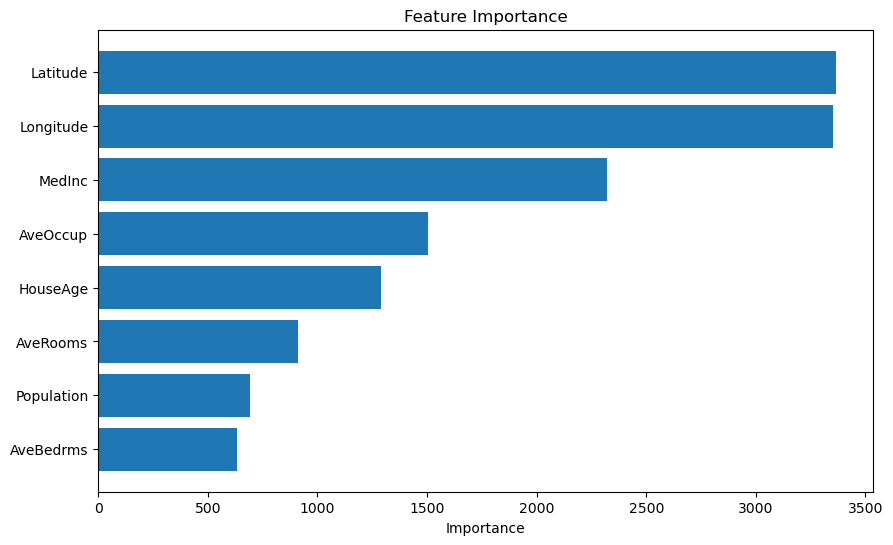

In [34]:
model.plot_importance()

In [35]:
model.predict(df.drop(columns=['target']))

array([4.27068135, 3.88838186, 4.14659996, ..., 0.78112146, 0.8573314 ,
       0.97145726])